<a href="https://colab.research.google.com/github/tbeucler/2022_ML_Earth_Env_Sci/blob/main/Lab_Notebooks/S2_2_Training_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Chapter 4 – Training Models**

<table align="left">
  <td align=middle>
    <a target="_blank" href="https://github.com/ageron/handson-ml2/blob/master/04_training_linear_models.ipynb"> Open the original notebook <br><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

Let's begin like in the last notebook: importing a few common modules, ensuring MatplotLib plots figures inline and preparing a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so once again we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

You don't need to worry about understanding everything that is written in this section.

In [5]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To make this notebook's output stable across runs
rnd_seed = 42
rnd_gen = np.random.default_rng(rnd_seed)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In this notebook we will be working with the [*Iris Flower Dataset*](https://en.wikipedia.org/wiki/Iris_flower_data_set), in which the length and width of both the sepals and petals of three types of Iris flowes were recorded. For reference, these are pictures of the three flowers: <br>

<center> In order: Iris Setosa,  Iris Versicolor, and Iris Virginica </center>

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/5/56/Kosaciec_szczecinkowaty_Iris_setosa.jpg/360px-Kosaciec_szczecinkowaty_Iris_setosa.jpg' height=300 >
<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/4/41/Iris_versicolor_3.jpg/640px-Iris_versicolor_3.jpg' height=300></img>
<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/9/9f/Iris_virginica.jpg/590px-Iris_virginica.jpg' height=300></img>

Photo Credits:[Kosaciec szczecinkowaty Iris setosa](https://en.wikipedia.org/wiki/File:Kosaciec_szczecinkowaty_Iris_setosa.jpg) by [Radomil Binek](https://commons.wikimedia.org/wiki/User:Radomil) licensed under [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/deed.en); [Blue flag flower close-up (Iris versicolor)](https://en.wikipedia.org/wiki/File:Iris_versicolor_3.jpg)by Danielle Langlois licensed under [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/deed.en); [image of Iris virginica shrevei](https://en.wikipedia.org/wiki/File:Iris_virginica.jpg) by [Frank Mayfield](https://www.flickr.com/photos/33397993@N05) licensed under [CC BY-SA 2.0](https://creativecommons.org/licenses/by-sa/2.0/deed.en).
<br><br>

As you can imagine, this dataset is normally used to train *multiclass*/*multinomial* classification algorithms and not *binary* classification algorithms, since there *are* more than 2 classes. 

"*Three classes, even!*" - an observant TA

For this exercise, however, we will be implemented the binary classification algorithm referred to as the *logistic regression* algorithm (also called logit regression).

In [6]:
# Let's load the Iris Dataset
from sklearn import datasets
iris = datasets.load_iris()

# Print out some information about the data
print(f'Keys in Iris dictionary: \n{list(iris.keys())}\n\n')
print(iris.DESCR)

# And load the petal lengths and widths as our input data
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

print(iris['data_module'])

# The target data labels Setosa as 0, Versicolor as 1, and Virginica as 2. For 
# this exercise we will be using only the Versicolor and Virgina sets.
bin_indices = np.logical_or(y==1,y==2)
bin_X = X[bin_indices]
bin_y = (y[bin_indices]==2).astype(np.uint8) # convert to binary

Keys in Iris dictionary: 
['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename']


.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    pe

KeyError: 'data_module'

We now have a set of binary classification data we can use to train an algorithm.

As we saw during our reading, we need to define three things in order to train our algorithm: the type of algorithm we will train, the cost function (which will tell us how close our prediction is to the truth), and a method for updating the parameters in our model according to the value of the cost function (e.g., the gradient descent method). 

Let's begin by defining the type of algorithm we will use. We will train a logistic regression model to differentiate between two classes. A reminder of how the logistic regression algorithm works is given below.
<br><br><br>
The logistic regression algorithm will thus take an input $t$ that is a linear combination of the features:

<a name="logit"></a>

<center> $t_{\small{n}} = \beta_{\small{0}} + \beta_{\small{1}} \cdot X_{1,n} + \beta_{\small{2}} \cdot X_{2,n}$ </center>

where 
* $n$ is the ID of the sample 
* $X_{\small{1}}$ represents the petal length
* $X_{\small{1}}$ represents the petal width

This input is then fed into the logistic function, $\sigma$:
\begin{align} 
\sigma: t\mapsto \dfrac{1}{1+e^ {-t}}
\end{align}

Let's plot it below to remember the shape of the function

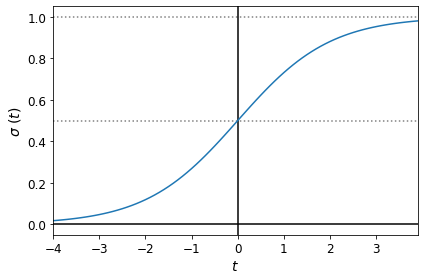

In [4]:
t = np.arange(-4,4,.1)
def logistic(in_val):
    # Return the value of the logistic function
    return 1/(1 + np.exp(- in_val))

fig, ax = plt.subplots()

ax.axvline(0, c='black', alpha=1)
ax.axhline(0, c='black', alpha=1)

[ax.axhline(y_val, c='black', alpha=0.5, linestyle='dotted') for y_val in (0.5,1)]

plt.autoscale(axis='x', tight=True)

ax.plot(t, logistic(t));
ax.set_xlabel('$t$')
ax.set_ylabel('$\\sigma\\  \\left(t\\right)$')
fig.tight_layout()

With the logistic function, we define inputs resulting in $\sigma\geq.5$ as belonging to the ***one*** class, and any value below that is considered to belong to the ***zero*** class.

We now have a function which lets us map the value of the petal length and width to the class to which the observation belongs (i.e., whether the length and width correspond to Iris Versicolor or Iris Virginica). However, there is a parameter vector **$\theta$** with a number of parameters that we do not have a value for: <br> $\theta = [ \beta_{\small{0}}, \beta_{\small{1}}$, $\beta_{\small{2}} ]$

**Q1) Set up an array of random numbers between 0 and 1 representing the $\theta$ vector.**

Hint:  Use `rnd_gen`! If you're not sure how to use it, consult the `default_rng` documentation [at this link](https://numpy.org/doc/stable/reference/random/generator.html). For instance, you may use the `random` method of `rnd_gen`.

In [42]:
import random
vec_0 = np.random.uniform(0, 1, (len(X),))
vec_0

array([0.6423306 , 0.27331036, 0.79132089, 0.50356252, 0.80706727,
       0.33075772, 0.1905524 , 0.53968283, 0.35094826, 0.44309538,
       0.70006137, 0.80357372, 0.97464213, 0.06629332, 0.5550718 ,
       0.96880837, 0.60665863, 0.5836664 , 0.99674159, 0.70586416,
       0.59621453, 0.55799204, 0.80610023, 0.18003846, 0.3357219 ,
       0.830803  , 0.18386847, 0.3011409 , 0.5436856 , 0.50100198,
       0.92740013, 0.03134947, 0.08120858, 0.86615148, 0.15884669,
       0.52612753, 0.17842992, 0.70134539, 0.70284101, 0.41362872,
       0.19344622, 0.82986795, 0.5540851 , 0.59681135, 0.22302956,
       0.27258913, 0.39171423, 0.71225783, 0.73092226, 0.2888248 ,
       0.61052732, 0.36327993, 0.31560447, 0.70106634, 0.50347628,
       0.73074893, 0.74368421, 0.36806731, 0.00936068, 0.61334452,
       0.69163753, 0.21272828, 0.79829593, 0.52498257, 0.3249907 ,
       0.69073047, 0.76808936, 0.7807387 , 0.78138634, 0.10919556,
       0.17749777, 0.37729574, 0.70869534, 0.35648802, 0.76011

In order to determine whether a set of $\beta$ values is better than the other, we need to quantify well the values are able to predict the class. This is where the cost function comes in.

The cost function, $c$, will return a value close to zero when the prediction, $\hat{p}$, is correct and a large value when it is wrong. In a binary classification problem, we can use the log loss function. For a single prediction and truth value, it is given by:
\begin{align}
        \text{c}(\hat{p},y) = \left\{
        \begin{array}{cl}
        -\log(\hat{p})& \text{if}\; y=1\\
        -\log(1-\hat{p}) & \text{if}\; y=0
        \end{array}
        \right.
    \end{align}

However, we want to apply the cost function to an n-dimensional set of predictions and truth values. Thankfully, we can find the average value of the log loss function $J$ for an an-dimensional set of $\hat{y}$ & $y$ as follows:

\begin{align}
        \text{J}(\mathbf{\hat{p}},y) = - \dfrac{1}{n} \sum_{i=1}^{n} 
        \left[ y_i\cdot \log\left( \hat{p}_i \right) \right] + 
        \left[ \left( 1 - y_i \right) \cdot \log\left( 1-\hat{p}_i \right) \right]
    \end{align}

We now have a formula that can be used to calculate the average cost over the training set of data.

**Q2) Define a log_loss function that takes in an arbitrarily large set of prediction and truths**

Hint 1: You need to encode the function $J$ above, for which Numpy's functions may be quite convenient (e.g., [`log`](https://numpy.org/doc/stable/reference/generated/numpy.log.html), [`mean`](https://numpy.org/doc/stable/reference/generated/numpy.mean.html), etc.)

Hint 2: Asserting the dimensions of the vector is a good way to check that your function is working correctly. [Here's a tutorial on how to use `assert`](https://swcarpentry.github.io/python-novice-inflammation/10-defensive/index.html#assertions). For instance, to assert that two vectors `X` and `Y` have the same dimension, you may use:
```
assert X.shape==Y.shape
```

Now let's code 💻

In [36]:
def log_loss(p_hat, y, epsilon=1e-7):
  # Write your code here. 
  # We can also run into problems if p_hat = 0, so add an _epsilon_ term
  # when evaluating log(p_hat).
  log_p_hat = epsilon + np.log(p_hat)
  
  J = -( (y*log_p_hat) + ((1-y)*np.log(1-p_hat)) )
  # -1/n * np.sum((y * log_p_hat) + ((1 - y) * np.log(1 - log_p_hat)))
  # After calculating J, assert that J has the same shape as p_hat and y
  assert J.shape == y.shape
  assert J.shape == p_hat.shape

  return

In [ ]:
def log_loss(p_hat, y, epsilon=1e-7):
    m = len(y)
    log_p_hat = epsilon + np.log(p_hat)
    J = (1 / m) * (y.T.dot(log_p_hat) - (1 - y).T.dot(np.log(1 - p_hat)))
    reg = (lambda_s/(2 * m)) * np.sum(theta**2)
    J = J + reg
 
    return J

We now have a way of quantifying how good our predictions are. The final thing needed for us to train our algorithm is figuring out a way to update the parameters in a way that improves the average quality of our predictions. 

<br><br>**Warning**: we'll go into a bit of math below <br><br>

Let's look at the change in a single parameter within $\theta$: $\beta_1$ (given $X_{1,i} = X_1$, $\;\hat{p}_{i} = \hat{p}$, $\;y_{i} = y$). If we want to know what the effect of changing the value of $\beta_1$ will have on the log loss function we can find this with the partial derivative:
<center>$
        \dfrac{\partial J}{\partial \beta_1}
$</center>

This may not seem very helpful by itself - after all, $\beta_1$ isn't even in the expression of $J$. But if we use the chain rule, we can rewrite the expression as:
<center>
        $\dfrac{\partial J}{\partial \hat{p}} \cdot
        \dfrac{\partial \hat{p}}{\partial \theta} \cdot
        \dfrac{\partial \theta}{\partial \beta_1}$
</center>

We'll spare you the math (feel free to verify it youself, however!):

<center>$\dfrac{\partial J}{\partial \hat{p}} =  \dfrac{\hat{p} - y}{\hat{p}(1-\hat{p})}, \quad
        \dfrac{\partial \hat{p}}{\partial \theta} = \hat{p} (1-\hat{p}), \quad
        \dfrac{\partial \theta}{\partial \beta_1} = X_1 $
</center>

and thus 
<center>$
        \dfrac{\partial J}{\partial \beta_1} = (\hat{p} - y) \cdot X_1
$</center>

We can calculate the partial derivative for each parameter in $\theta$ which, as you may have realized, is simply the $\theta$ gradient of $J$: $\nabla_{\theta}(J)$

With all of this information, we can now write $\nabla_{\theta} J$ in terms of the error, the feature vector, and the number of samples we're training on!

<a name="grad_eq"></a>

<center>$\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\theta^{(k)}}) = \dfrac{1}{n} \sum\limits_{i=1}^{n}{ \left ( \hat{p}^{(k)}_{i} - y_{i} \right ) \mathbf{X}_{i}}$</center>

Note that here $k$ represents the iteration of the parameters we are currently on.

We now have a gradient we can calculate and use in the batch gradient descent method! The updated parameters will thus be:

<a name="grad_descent"></a>

\begin{align} 
{\mathbf{\theta}^{(k+1)}} = {\mathbf{\theta}^{(k)}} - \eta\,\nabla_{\theta^{(k)}}J(\theta^{(k)})
\end{align}

Where $\eta$ is the learning rate parameter. It's also worth pointing out that $\;\hat{p}^{(k)}_i = \sigma\left(\theta^{(k)}, X_i\right) $

In order to easily calculate the input to the logistic regression, we'll multiply the $\theta$ vector with the X data, and as we have a non-zero bias  $\beta_0$ we'd like to have an X matrix whose first column is filled with ones.

\begin{align}
    X_{\small{with\ bias}} = \begin{pmatrix}
        1 & X_{1,0} & X_{2,0}\\
        1 & X_{1,1} & X_{2,1}\\
        &...&\\
        1 & X_{1,n} & X_{2,n} 
        \end{pmatrix}
\end{align}
<br>
**Q3) Prepare the `X_with_bias` matrix (remember to use the `bin_X` data and not just `X`). Write a function called `predict` that takes in the parameter vector $\theta$ and the `X_with_bias` matrix and evaluates the logistic function for each of the samples.**

Hint 1: You recently learned how to initialize arrays in the `Numpy` notebook [at this link](https://nbviewer.org/github/tbeucler/2022_ML_Earth_Env_Sci/blob/main/Lab_Notebooks/S1_2_Numpy.ipynb). There are many ways to add a columns of 1 to `bin_X`, for instance using [`np.concatenate`](https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html) or [`np.append`](https://numpy.org/doc/stable/reference/generated/numpy.append.html).

Hint 2:  To clarify, the function `predict` calculates $\hat{p}$ from $\beta$ and $\boldsymbol{X}$.

Hint 3: In practice, to calculate the logistic function for each sample, you may follow the equations [higher up in the notebook](#logit) and (1) calculate $t$ from $\beta$ and $\boldsymbol{X_{\mathrm{with\ bias}}}$ before (2) applying the logistic function $\sigma$ to $t$. 

In [37]:
# Prepare the X_with_bias matrix

X_with_bias = np.c_[np.ones([len(X), 1]), X]

In [47]:
# Write your function predict here
predict = 
#np.linalg.inv(X_with_bias .T.dot(X_with_bias)).dot(X_with_bias.T).dot(vec_0)
#np.dot(X,vec_0)

**Q4) Now that you have a `predict` function, write a `gradient_calc` function that calculates the gradient for the logistic function.**

Hint 1: You'll have to feed `theta`, `X`, and `y` to the `gradient_calc` function.

Hint 2: You can use [this equation](#grad_eq) to calculate the gradient of the cost function.

In [50]:
# Write your code here

def gradient_calc(theta, x, y): # FEED N?
    return ((1/n)*np.sum(predict - y)*X)   

In [ ]:
def gradient_calc(theta, X, y):
    m, n = X.shape
    theta = theta.reshape((n, 1))
    y = y.reshape((m, 1))
    h = sigmoid(X.dot(theta))
    
    gd = ((1 / m) * X.T.dot(h - y)) 
    
    return gd

We can now write a function that will train a logistic regression algorithm!

Your `logistic_regression` function needs to:
* Take in a set of training input/output data, validation input/output data, a number of iterations to train for, a set of initial parameters $\theta$, and a learning rate $\eta$
* At each iteration:
 * Generate a set of predictions on the training data. Hint: You may use your function `predict` on inputs `X_train` from the training set.
 * Calculate and store the loss function for the training data at each iteration. Hint: You may use your function `log_loss` on inputs `X_train` and outputs `y_train` from the training set.
 * Calculate the gradient. Hint: You may use your function `grad_calc`.
 * Update the $\theta$ parameters. Hint: You need to implement [this equation](#grad_descent).
 * Generate a set of predictions on the validation data using the updated parameters. Hint: You may use your function `predict` on inputs `X_valid` from the validation set. 
 * Calculate and store the loss function for the validation data. Hint: You may use your function `log_loss` on inputs `X_valid` and outputs `y_valid` from the validation set. 
 * Bonus: Calculate and store the accuracy of the model on the training and validation data as a metric!
* Return the final set of parameters $\theta$ & the stored training/validation loss function values (and the accuracy, if you did the bonus)

**Q5) Write the `logistic_regression` function**

In [ ]:
# Write your code here
def logistic_regression(X, y):
    result = op.minimize(fun = log_loss, args = (X, y),
                         method = 'TNC', jac = gradient_calc)
    
    return result.x
    

**¡¡¡Important Note!!!**

The notebook assumes that you will return 
1. a Losses list, where Losses[0] is the training loss and Losses[1] is the validation loss
2. a tuple with the 3 final coefficients ($\beta_0$, $\beta_1$, $\beta_2$)

The code for visualizing the bonus accuracy is not included - but it should be simple enough to do in a way similar to that which is done with the losses.

---------------------

Now that we have our logistic regression function, we're all set to train our algorithm! Or are we?

There's an important data step that we've neglected up to this point - we need to split the data into the train, validation, and test datasets.

In [ ]:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

rnd_indices = rnd_gen.permutation(total_size)

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = bin_y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = bin_y[rnd_indices[train_size:-test_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = bin_y[rnd_indices[-test_size:]]

Now we're ready! 

**Q6) Train your logistic regression algorithm. Use 5000 iterations, $\eta$=0.1**

Hint: It's time to use the `logistic_regression` function you defined in Q5. 

In [ ]:
# Complete the code
losses, coeffs = logistic_regression()

Let's see how our model did while learning!

In [ ]:
# Produce the Loss Function Visualization Graphs
fig, ax = plt.subplots(figsize=(18,8))
ax.plot(losses[0], color='blue', label='Training', linewidth=3);
ax.plot(losses[1], color='orange', label='Validation', linewidth=3);
ax.legend();
ax.set_ylabel('Log Loss')
ax.set_xlabel('Iterations')
ax.set_title('Loss Function Graph')
ax.autoscale(axis='x', tight=True)
fig.tight_layout();

# Let's get predictions from our model for the training, validation, and testing
# datasets
y_hat_train = (predict(X_train, coeffs)>=.5).astype(int)
y_hat_valid = (predict(X_valid, coeffs)>=.5).astype(int)
y_hat_test = (predict(X_test, coeffs)>=.5).astype(int)

y_sets = [ [y_hat_train, y_train],
           [y_hat_valid, y_valid],
           [y_hat_test, y_test] ]

def accuracy_score(y_hat, y):
    assert(y_hat.size==y.size)
    return (y_hat == y).sum()/y.size

[accuracies.append(accuracy_score(y_set[0],y_set[1])) for y_set in y_sets]

printout= (f'Training Accuracy:{accuracies[0]:.1%} \n'
           f'Validation Accuracy:{accuracies[1]:.1%} \n')

# Add the testing accuracy only once you're sure that your model works!


print(printout)

Congratulations on training a logistic regression algorithm from scratch! Once you're done with the upcoming environmental science applications notebook, feel free to come back to take a look at the challenges 😀

## Challenges

* **C1)** Add L2 Regularization to training function 

* **C2)** Add early stopping to the training algorithm! Stop training when the accuracy is >=90%

* **C3)** Implement a softmax regression model (It's multiclass logistic regression 🙂)